In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
import pandas as pd
import pandas.io.sql as pandasql
import datetime
from psycopg2 import connect

In [2]:
#Setting up postgresql connection
con = connect(database='rdumas',host='localhost',port='5433',user='rdumas')

In [3]:
#Ostensibly prevents plotting when using the save_fig command, but I've seen no evidence of success
#http://stackoverflow.com/a/15713545/4047679
plt.ioff()
plt.style.use('ggplot')

In [4]:
'''
Setting colours
http://stackoverflow.com/a/37211181/4047679
Blue: #004B85
Red: #F2756D
'''
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#004B85','#F2756D'])

In [8]:
#sql = "SELECT pretty_quarter(quarter::date) as quarter, corridor, direction, period,tt_med as median_tt, tt_95th - tt_med as buffer_time "\
#        "FROM rdumas.key_corridor_perf "\
#        "INNER JOIN rdumas.key_corridor_lookup USING (corridor_id)"\
#        "WHERE daytype = 'Midweek' and period IN ('AMPK','PMPK') "\
#        "ORDER BY corridor, direction, period, quarter"
sql = "SELECT dt_mon::date, corridor, direction, period,tt_med as median_tt, tt_95th - tt_med as buffer_time "\
      "FROM rdumas.key_corridor_perf_alldata "\
      "INNER JOIN rdumas.key_corridor_lookup USING (corridor_id) "\
      "WHERE daytype = 'Midweek' and period IN ('AMPK','PMPK') "\
      "ORDER BY corridor, direction, period, dt_mon"
key_corridors_perf = pandasql.read_sql(sql, con)

In [9]:
dirs = key_corridors_perf.direction.unique()
peaks = key_corridors_perf.period.unique()
corridors = pandasql.read_sql("SELECT corridor, direction FROM key_corridor_lookup", con)

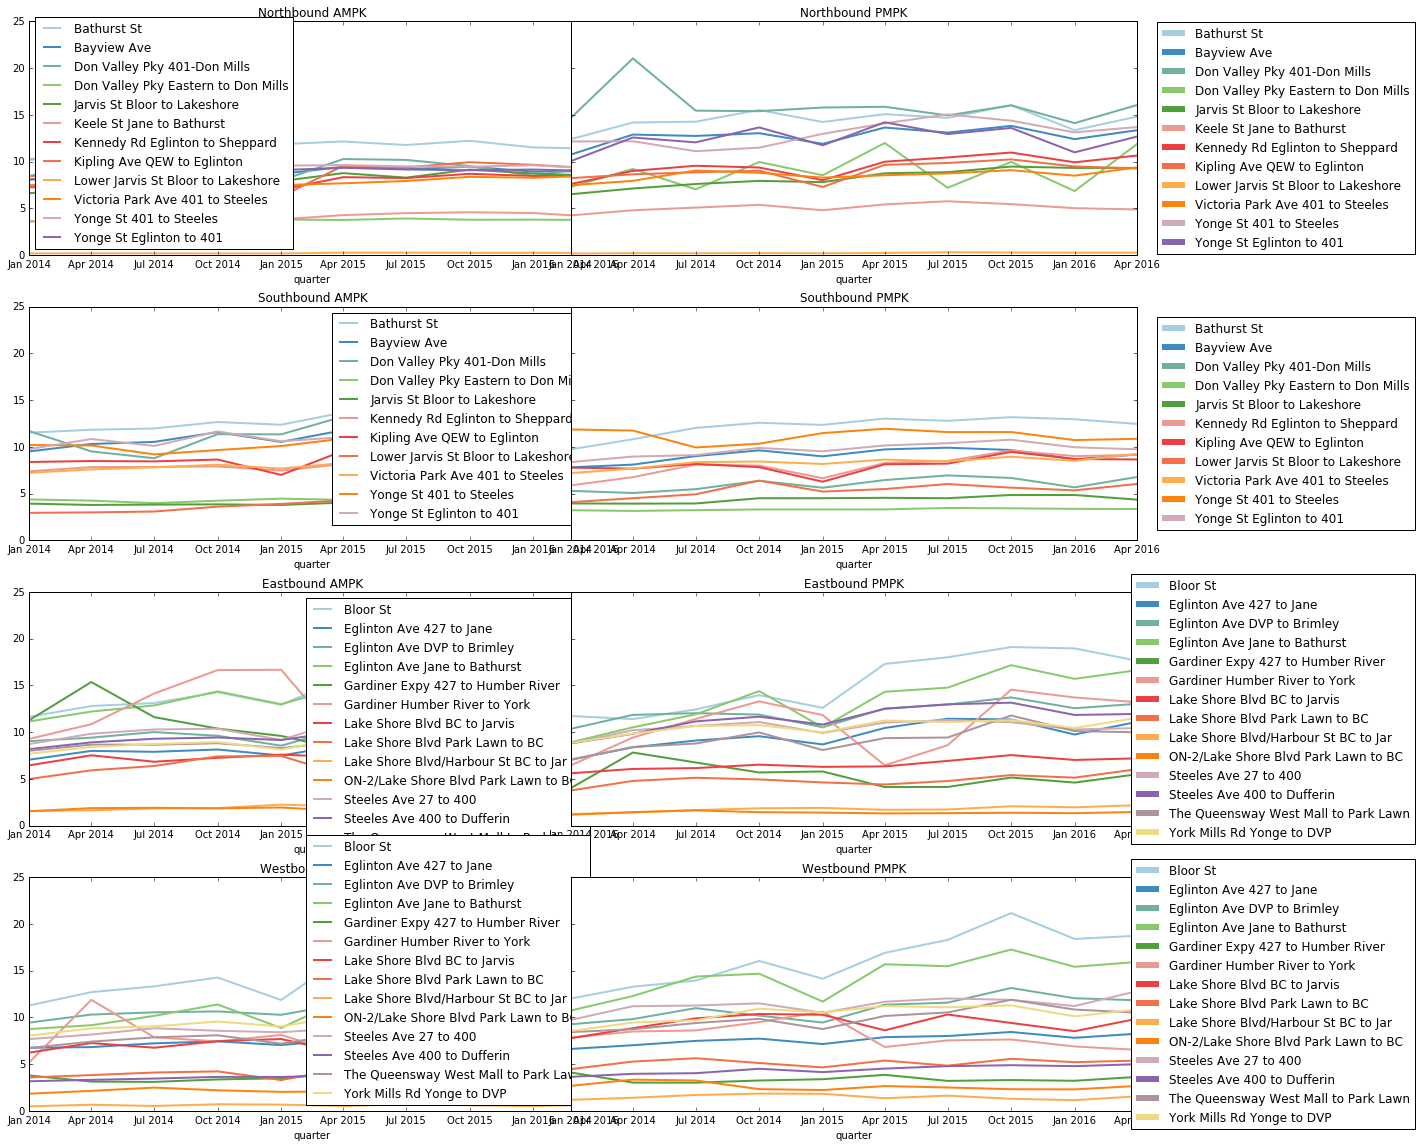

In [46]:
fig, ax = plt.subplots(4,2, figsize=(16,16), sharey=True)

#Setting colors
NUM_COLORS = 14
cm = plt.get_cmap('Paired')
color_cycler = cycler('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

ax_r = -1

for dir in dirs:
    ax_r = ax_r + 1
    ax_c = -1
    for pk in peaks:
        ax_c = ax_c + 1
        ax[ax_r,ax_c].set_prop_cycle(color_cycler)
        for corr in corridors[corridors["direction"]==dir].corridor.sort_values():
            key_corridors_perf[(key_corridors_perf["corridor"]==corr)
                               & (key_corridors_perf["period"]==pk)
                               & (key_corridors_perf["direction"]==dir)].plot(x='quarter',
                                                                              y='median_tt',
                                                                              linewidth=2,
                                                                              ax=ax[ax_r,ax_c],
                                                                              label=corr
                                                                             )
        ax[ax_r,ax_c].set_title(dir + ' ' + pk)
        box = ax[ax_r,ax_c].get_position()
        ax[ax_r,ax_c].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    leg = ax[ax_r,1].legend(loc='right',bbox_to_anchor=(1.5,0.5))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)

            
plt.tight_layout()
plt.show()

In [84]:
'''Buffer Time Plots'''
#Setting colors
NUM_COLORS = 2
cm = plt.get_cmap('Paired')
color_cycler = cycler('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

fig_list = []

for corridor in key_corridors_perf.corridor.unique():
    fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
    ax_c = -1
    for pk in peaks:
        ax_c = ax_c + 1
        ax[ax_c].set_prop_cycle(color_cycler)
        for direction in corridors[corridors["corridor"]==corridor].direction:
            key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                               & (key_corridors_perf["direction"]==direction)
                               & (key_corridors_perf["period"]==pk)].plot(x='quarter',
                                                                          y='buffer_time',
                                                                          linewidth=2,
                                                                          ax=ax[ax_c],
                                                                          label=direction
                                                                         )
        ax[ax_c].set_title(pk)
        ax[ax_c].set_autoscaley_on(False)
        ax[ax_c].set_ylim([0,22])
    fig.set_title(corridor)
    ax[0].legend().set_visible(False)
    leg = ax[1].legend(loc='center right',bbox_to_anchor=(1.2,0.5))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)
    fig.savefig('H:/prj_congestion/buffer_time_plots/'+ corridor +'.png', format='png', transparent=True)
    plt.close(fig)

In [92]:
'''Median Travel Time Plots'''
#Setting colors
NUM_COLORS = 2
cm = plt.get_cmap('Paired')
color_cycler = cycler('color',[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

fig_list = []

for corridor in key_corridors_perf.corridor.unique():
    fig, ax = plt.subplots(1,2, figsize=(16,4), sharey=True)
    fig_list.append(fig)
    ax_c = -1
    for pk in peaks:
        ax_c = ax_c + 1
        ax[ax_c].set_prop_cycle(color_cycler)
        for direction in corridors[corridors["corridor"]==corridor].direction.sort_values():
            key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                               & (key_corridors_perf["direction"]==direction)
                               & (key_corridors_perf["period"]==pk)].plot(x='quarter',
                                                                          y='median_tt',
                                                                          linewidth=2,
                                                                          ax=ax[ax_c],
                                                                          label=direction
                                                                         )
        ax[ax_c].set_title(pk)
        ax[ax_c].set_autoscaley_on(False)
        ax[ax_c].set_ylim([0,22])
    fig.suptitle(corridor, fontsize=16)
    ax[0].set_ylabel('Median Travel Time (min)')
    ax[0].legend().set_visible(False)
    leg = ax[1].legend(loc='center right',bbox_to_anchor=(1.3,0.5))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)
    fig.savefig('H:/prj_congestion/median_tt_plots/'+ corridor +'.png', format='png', transparent=True)
    plt.close(fig)

In [73]:
'''Summary Table'''
sql = "SELECT corridor, direction, left(direction,1)||'B' as dir, period, "\
      "lpad(to_char(100*(q2.tt_med - q1.tt_med)/q1.tt_med, 'FMSG990.0'),6)||'%' AS median_tt, "\
      "lpad(to_char(100*(q2.tt_95th - q1.tt_95th - (q2.tt_med - q1.tt_med))/(q1.tt_95th-q1.tt_med),'FMSG990.0'),6)||'%' AS buffer_time "\
      "FROM key_corridor_perf q1 "\
      "INNER JOIN key_corridor_perf q2 USING (corridor_id, daytype,period) "\
      "INNER JOIN key_corridor_lookup USING (corridor_id) "\
      "WHERE daytype = 'Midweek'  "\
      "AND q1.quarter = '2014-04-01' AND q1.period IN ('AMPK','PMPK') "\
      "AND q2.quarter = '2016-04-01' AND q2.period IN ('AMPK','PMPK') "\
      "ORDER BY corridor, direction"
q2q2table = pandasql.read_sql(sql,con)

In [40]:
'''Combined Plot (quarterly data)'''

for corridor in key_corridors_perf.corridor.unique():
    fig, ax = plt.subplots(2,2, figsize=(16,9), sharey=False)
    ax_c = -1
    handles = []
    labels = []
    colors=['#004B85','#F2756D']
    for pk in peaks:
        ax_c = ax_c + 1
        for direction in corridors[corridors["corridor"]==corridor].direction.sort_values():
            key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                               & (key_corridors_perf["direction"]==direction)
                               & (key_corridors_perf["period"]==pk)].plot(x='quarter',
                                                                          y='median_tt',
                                                                          linewidth=2,
                                                                          ax=ax[0,ax_c],
                                                                          label=direction
                                                                         )
            key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                               & (key_corridors_perf["direction"]==direction)
                               & (key_corridors_perf["period"]==pk)].plot(x='quarter',
                                                                          y='buffer_time',
                                                                          linewidth=2,
                                                                          ax=ax[1,ax_c],
                                                                          label=direction
                                                                         )
        ax[0,ax_c].set_ylim([0,22])
        ax[1,ax_c].set_ylim([0,18])
        for i in range(0,2):
            ax[i,ax_c].set_autoscaley_on(False)
            ax[i,ax_c].legend().set_visible(False)

    for i, direction in enumerate(corridors[corridors["corridor"]==corridor].direction.sort_values()):
        handles.append(mpl.lines.Line2D([], [], color=colors[i],
                          label=direction, linewidth=6.0))
        labels.append(direction)    

    ax[0,0].set_ylabel('Median Travel Time (min)')
    ax[1,0].set_ylabel('Buffer Time (min)')
    fig.legend(handles=handles, labels=labels, loc='lower center')
    fig.savefig('corridors/combined_plots/'+ corridor +'.svg', format='svg', transparent=False)
    plt.close(fig)

In [98]:
'''Combined Plot (monthly) with annotation'''
ylim = [0,25]
q2_q2 = [dict(x1=datetime.date(2014,4,1), x2=datetime.date(2014,6,1), xy=(datetime.date(2014,5,1),ylim[1]-1), text='2014\nQ2'),
         dict(x1=datetime.date(2016,4,1), x2=datetime.date(2016,6,1), xy=(datetime.date(2016,5,1),ylim[1]-1), text='2016\nQ2')]
colors=['#004B85','#F2756D']
fig_format='png'

for corridor in key_corridors_perf.corridor.unique():
    fig, ax = plt.subplots(2,2, figsize=(16,9), sharex=True, sharey=True)
    ax_c = -1
    handles = []
    labels = []

    for pk in peaks:
        ax_c = ax_c + 1
        for ax_r, y in enumerate(['median_tt','buffer_time']):
            txtbox = []
            for direction in corridors[corridors["corridor"]==corridor].direction.sort_values():
                key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                                   & (key_corridors_perf["direction"]==direction)
                                   & (key_corridors_perf["period"]==pk)].plot(x='dt_mon',
                                                                              y=y,
                                                                              linewidth=2,
                                                                              ax=ax[ax_r,ax_c],
                                                                              label=direction
                                                                             )
                #Text box
                q2data = q2q2table.loc[(q2q2table["corridor"]==corridor)
                                                     & (q2q2table["direction"]==direction)
                                                     & (q2q2table["period"]==pk), ['dir',y]]
                dir = q2data.iloc[0]['dir']
                value = q2data.iloc[0][y]
                txtbox.append(dir + ':  ' + value)
            #Quarter-Quarter Performance change text box
            textstr = 'Q2-Q2 Change\n'+txtbox[0] + '\n' + txtbox[1]
            txtprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax[ax_r,ax_c].text(0.9,0.95, textstr, family='monospace', transform=ax[ax_r,ax_c].transAxes,
                               verticalalignment='top', horizontalalignment='right', bbox=txtprops)
            
            ax[ax_r,ax_c].set_autoscaley_on(False)
            ax[ax_r,ax_c].legend().set_visible(False)
            #First Quarter band    
            ax[ax_r,ax_c].axvspan(q2_q2[0]['x1'], q2_q2[0]['x2'], alpha=0.5)
            ax[ax_r,ax_c].annotate(q2_q2[0]['text'], xy=q2_q2[0]['xy'], xytext=q2_q2[0]['xy'],
                                   verticalalignment='top', horizontalalignment='center')
            #Second Quarter band    
            ax[ax_r,ax_c].axvspan(q2_q2[1]['x1'], q2_q2[1]['x2'], alpha=0.5, label='2016 Q2')
            ax[ax_r,ax_c].annotate(q2_q2[1]['text'], xy=q2_q2[1]['xy'], xytext=q2_q2[1]['xy'],
                                   verticalalignment='top', horizontalalignment='center')

        ax[1,ax_c].set_xlabel('Month')
        ax[1,ax_c].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,3)))

        ax[0,ax_c].set_ylim(ylim)

    for i, direction in enumerate(corridors[corridors["corridor"]==corridor].direction.sort_values()):
        handles.append(mpl.lines.Line2D([], [], color=colors[i],
                          label=direction, linewidth=6.0))
        labels.append(direction)    

    ax[0,0].set_ylabel('Median Travel Time (min)')
    ax[1,0].set_ylabel('Buffer Time (min)')

    fig.legend(handles=handles, labels=labels, loc='lower center')
    plt.gcf().autofmt_xdate()
    plt.minorticks_off()
    fig.savefig('corridors/combined_plots/'+ corridor +'.'+fig_format, format=fig_format, transparent=False)
    plt.close(fig)

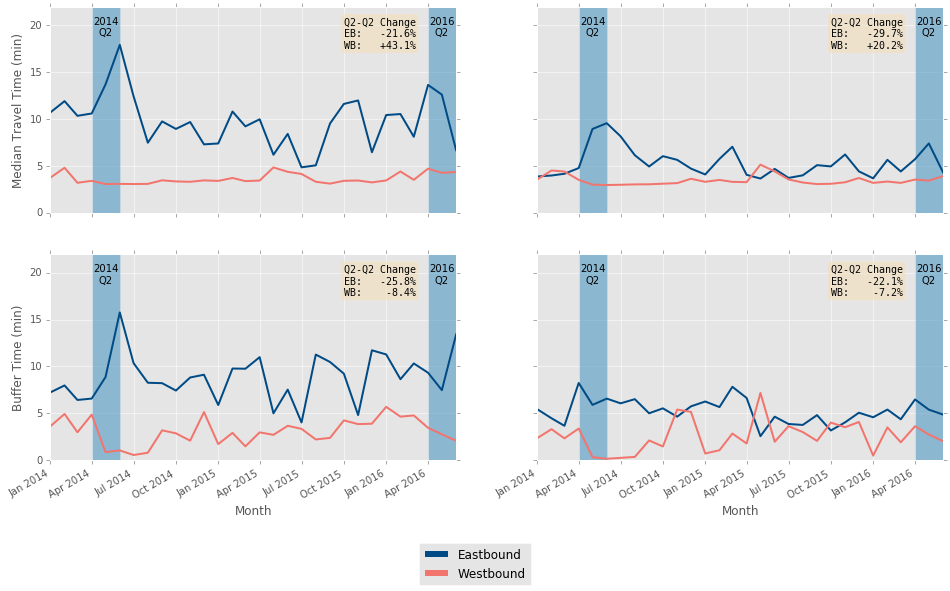

In [90]:
'''For testing'''
corridor = 'Gardiner Expy- 427 to Humber River'
fig, ax = plt.subplots(2,2, figsize=(16,9), sharex=True, sharey=True)
ax_c = -1
handles = []
labels = []
colors=['#004B85','#F2756D']



for pk in peaks:
    ax_c = ax_c + 1
    for ax_r, y in enumerate(['median_tt','buffer_time']):
        txtbox = []
        for direction in corridors[corridors["corridor"]==corridor].direction.sort_values():
            key_corridors_perf[(key_corridors_perf["corridor"]==corridor)
                               & (key_corridors_perf["direction"]==direction)
                               & (key_corridors_perf["period"]==pk)].plot(x='dt_mon',
                                                                          y=y,
                                                                          linewidth=2,
                                                                          ax=ax[ax_r,ax_c],
                                                                          label=direction
                                                                         )
            #Text box
            q2data = q2q2table.loc[(q2q2table["corridor"]==corridor)
                                                 & (q2q2table["direction"]==direction)
                                                 & (q2q2table["period"]==pk), ['dir',y]]
            dir = q2data.iloc[0]['dir']
            value = q2data.iloc[0][y]
            txtbox.append(dir + ':  ' + value)
    
        textstr = 'Q2-Q2 Change\n'+txtbox[0] + '\n' + txtbox[1]
        ax[ax_r,ax_c].set_autoscaley_on(False)
        ax[ax_r,ax_c].legend().set_visible(False)
        txtprops = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax[ax_r,ax_c].text(0.9,0.95, textstr, family='monospace', transform=ax[ax_r,ax_c].transAxes,
                           verticalalignment='top', horizontalalignment='right', bbox=txtprops)
        ax[ax_r,ax_c].axvspan(datetime.date(2014,4,1), datetime.date(2014,6,1), alpha=0.5)
        ax[ax_r,ax_c].annotate('2014\nQ2', xy=(datetime.date(2014,5,1),21), xytext=(datetime.date(2014,5,1),21),
                               verticalalignment='top', horizontalalignment='center')
        ax[ax_r,ax_c].axvspan(datetime.date(2016,4,1), datetime.date(2016,6,1), alpha=0.5, label='2016 Q2')
        ax[ax_r,ax_c].annotate('2016\nQ2', xy=(datetime.date(2016,5,1),21), xytext=(datetime.date(2016,5,1),21),
                               verticalalignment='top', horizontalalignment='center')

    ax[1,ax_c].set_xlabel('Month')
    ax[1,ax_c].xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=range(1,13,3)))
    
    ax[0,ax_c].set_ylim([0,22])
    #ax[1,ax_c].set_ylim([0,22])

for i, direction in enumerate(corridors[corridors["corridor"]==corridor].direction.sort_values()):
    handles.append(mpl.lines.Line2D([], [], color=colors[i],
                      label=direction, linewidth=6.0))
    labels.append(direction)    

ax[0,0].set_ylabel('Median Travel Time (min)')
ax[1,0].set_ylabel('Buffer Time (min)')

fig.legend(handles=handles, labels=labels, loc='lower center')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
#plt.tight_layout()
plt.show()

In [64]:
corridor = 'Gardiner Expy- 427 to Humber River'
pk = 'AMPK'
direction = 'Eastbound'
y = 'buffer_time'
q2data = q2q2table.loc[(q2q2table["corridor"]==corridor)
                                                 & (q2q2table["direction"]==direction)
                                                 & (q2q2table["period"]==pk), ['dir',y]]
q2data.iloc[0]['dir']

'EB'

In [78]:
datetime.date(2014,4,1)

datetime.date(2014, 4, 1)